In [4]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

from ipywidgets import IntProgress
from IPython.display import display, clear_output
import IPython

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [5]:
xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/home/andrei/code/andrei-ka/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [15]:
raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]


In [7]:
sampling=50 #sampling rate
win_len=20  #wind size in secs
tot_frame_len=sampling*win_len
act_types=np.sort(data[categ_colname].unique())
n_act_types=len(act_types)

In [14]:
#lets build jpegs from sensor data, it's fun for feature engineering...
#here we work just on a single participant

ts_field='datime_WD'  #cleaned up one

participant="Participant2"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)

def to_255(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * 255

sensor="gyro"

# our rgb-likes & sensor weights
if sensor == "accel" :  
  sensors=['Accelerometer_x_WD', 
           'Accelerometer_y_WD', 
           'Accelerometer_z_WD'] 
  sensors_weights={ "Accelerometer_x_WD": 5.0, 
                    "Accelerometer_y_WD": 5.0, 
                    "Accelerometer_z_WD": 1.0 }

if sensor == "accel_lin" :  
  sensors=['Linear_acceleration_sensor_x_WD', 
           'Linear_acceleration_sensor_y_WD', 
           'Linear_acceleration_sensor_z_WD'] 
  sensors_weights={ "Linear_acceleration_sensor_x_WD": 1.0,
                    "Linear_acceleration_sensor_y_WD": 1.0, 
                    "Linear_acceleration_sensor_z_WD": 1.0 }

if sensor == "gyro" :
  sensors=['Gyroscope_x_PD', 
           'Gyroscope_y_PD', 
           'Gyroscope_z_PD'] 
  sensors_weights={ "Gyroscope_x_PD": 1.0, 
                    "Gyroscope_y_PD": 1.0, 
                    "Gyroscope_z_PD": 5.0 }
    
sampling=50 #sampling rate
win_len=60  #wind size in secs

n_sensors=len(sensors) #outta be [1,3] for images...

tot_frame_len=int(sampling*win_len)

act_types=np.sort(data[categ_colname].unique())
n_act_types=len(act_types)

#build images lists
act_rgb={} #images per activity 

max_count = int(len(data)/tot_frame_len)
print("expecting approx {} images in total...".format(max_count))

pbar = IntProgress(min=0, max=max_count) 
display(pbar) 

def act_2_rgb(data, act_rgb, act_type):
  data_cursor = data[(data[categ_colname] == act_type)].copy() 
  data_act_type_len=len(data_cursor)-tot_frame_len
                         
  if data_act_type_len < tot_frame_len : 
     print("start skipping {} cur not enugh for at least 1 frame...".format(act_type))
     return

  data2=data_cursor.sort_values(by=ts_field, ignore_index=True)
  data_cursor=data2.reset_index(drop=True)

  act_rgb[act_type]=[]

  max_count_act = int(len(data_cursor)/tot_frame_len)
  print("expecting approx {} {} images in total...".format(act_type, max_count_act))
    
  nth_frame=0 
  
  while True:      
    cur_pos=nth_frame*tot_frame_len
    if cur_pos > data_act_type_len :   break           
    end_pos=cur_pos+tot_frame_len    
    data_tmp=data_cursor[cur_pos:end_pos] 
    
    #fill rgb frame from data_tmp...
    raw_data = [] 
    _cur_pos = 0
        
    for nth_sec in range(0, win_len) :
      if _cur_pos == tot_frame_len :  break
        
      for nrow in range(0, sampling) :
         _cur_pos=sampling*nth_sec+nrow
         if _cur_pos == tot_frame_len : break           
         row=data_tmp.iloc[_cur_pos]            

         for fld in sensors :
            raw_data.append(row[fld] * sensors_weights[fld])          
    
    act_rgb[act_type].append(Image.fromarray(np.array(to_255(raw_data), dtype=np.uint8).reshape(sampling, win_len, n_sensors))) 
    nth_frame+=1
        
    pbar.value += 1   
    if pbar.value % 20 == 0:
       print("{} images of {}".format(20, act_type))
    
  print("processed {} frames of {}".format(nth_frame, act_type))
  return

for act_type in act_types :
   act_2_rgb(data, act_rgb, act_type)             

expecting approx 329 images in total...


IntProgress(value=0, max=329)

expecting approx DrinkSD 47 images in total...
20 images of DrinkSD
20 images of DrinkSD
processed 47 frames of DrinkSD
expecting approx DrinkST 47 images in total...
20 images of DrinkST
20 images of DrinkST
processed 47 frames of DrinkST
expecting approx Eat 47 images in total...
20 images of Eat
20 images of Eat
20 images of Eat
processed 47 frames of Eat
expecting approx Sit 47 images in total...
20 images of Sit
20 images of Sit
processed 47 frames of Sit
expecting approx SmokeSD 47 images in total...
20 images of SmokeSD
20 images of SmokeSD
processed 47 frames of SmokeSD
expecting approx SmokeST 47 images in total...
20 images of SmokeST
20 images of SmokeST
20 images of SmokeST
processed 47 frames of SmokeST
expecting approx Stand 47 images in total...
20 images of Stand
20 images of Stand
processed 47 frames of Stand


In [10]:
for act_type in act_types :    
  print("made {} frames for activty {}".format(len(act_rgb[act_type]), act_type))

made 47 frames for activty DrinkSD
made 47 frames for activty DrinkST
made 47 frames for activty Eat
made 47 frames for activty Sit
made 47 frames for activty SmokeSD
made 47 frames for activty SmokeST
made 47 frames for activty Stand


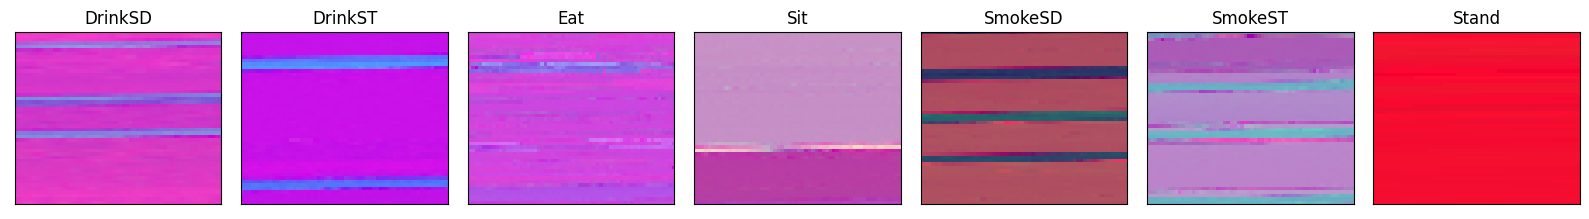

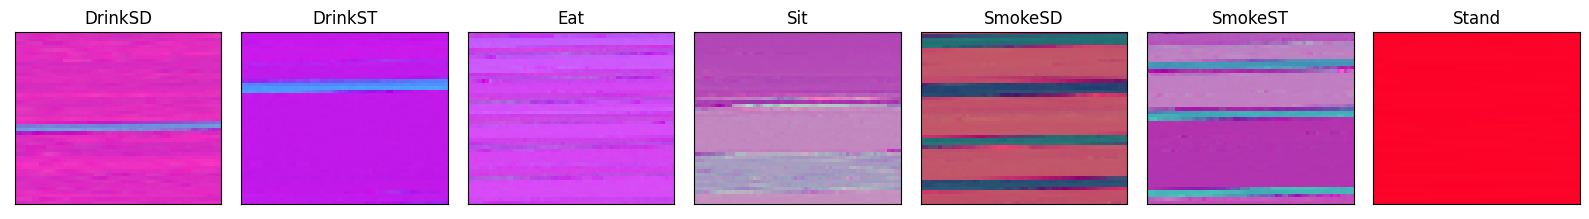

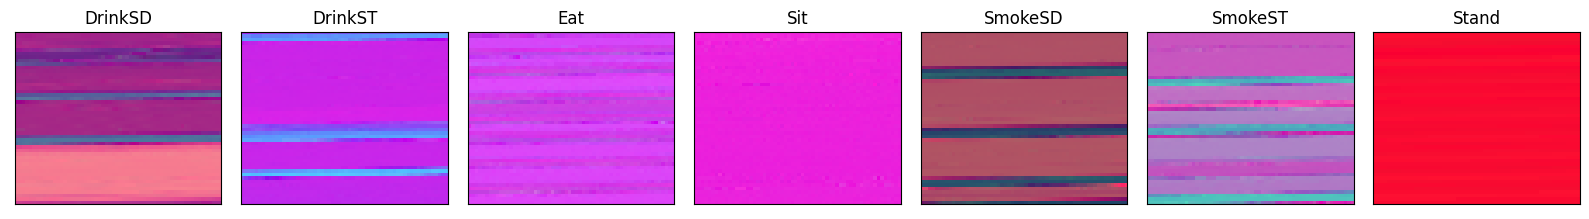

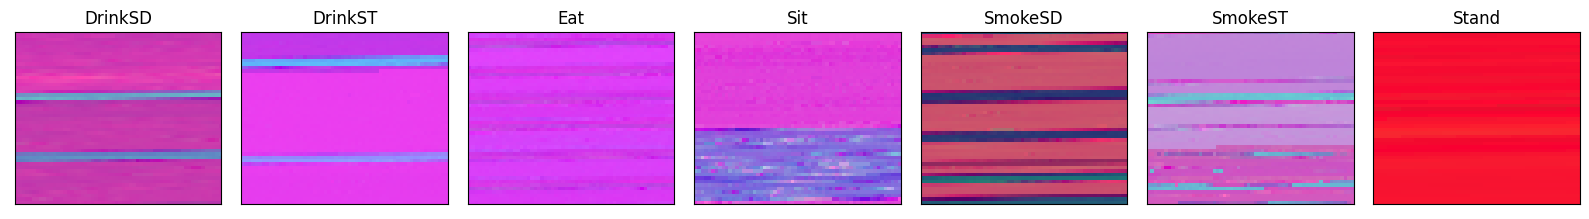

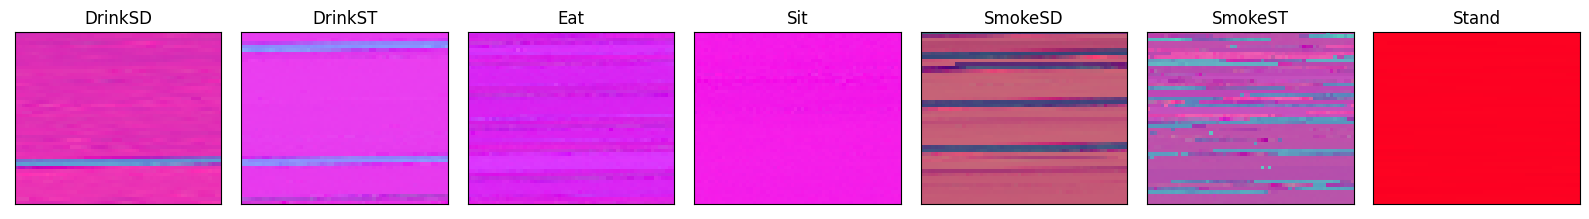

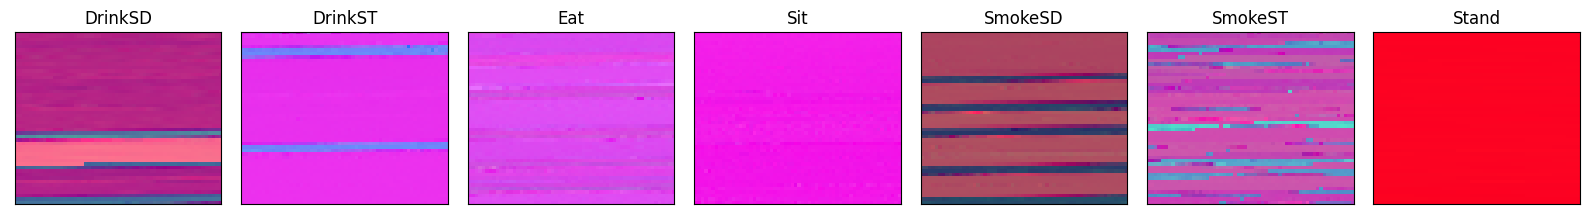

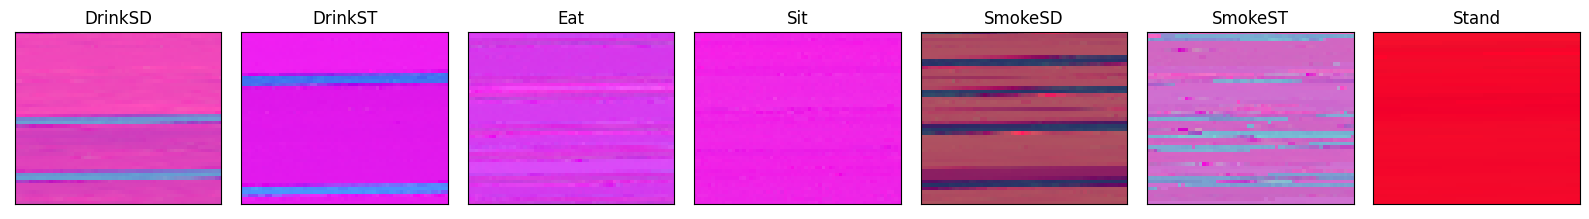

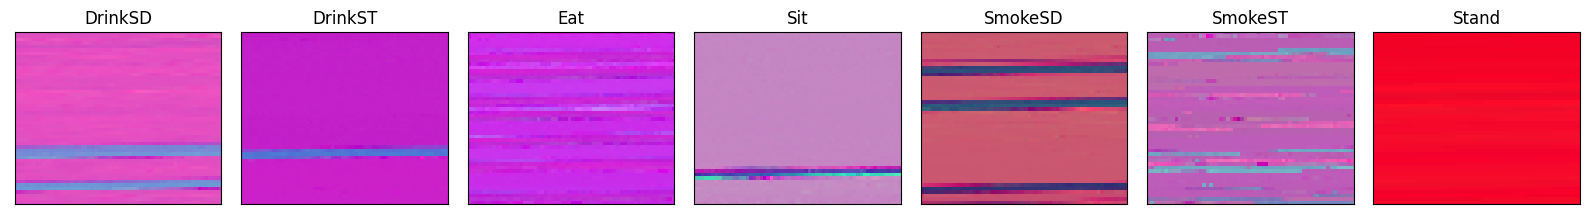

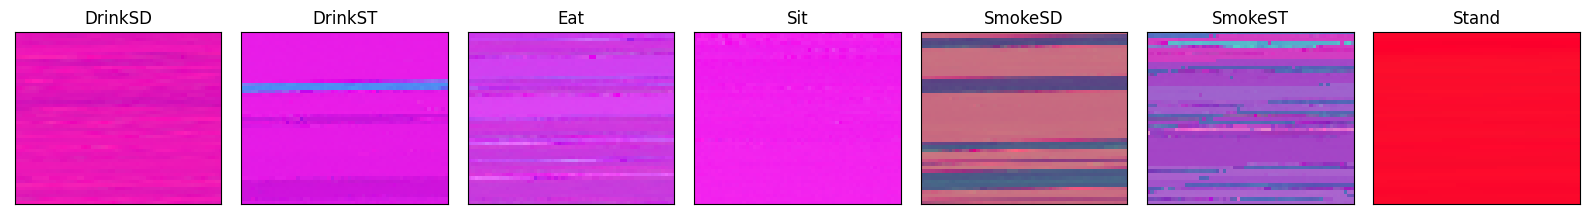

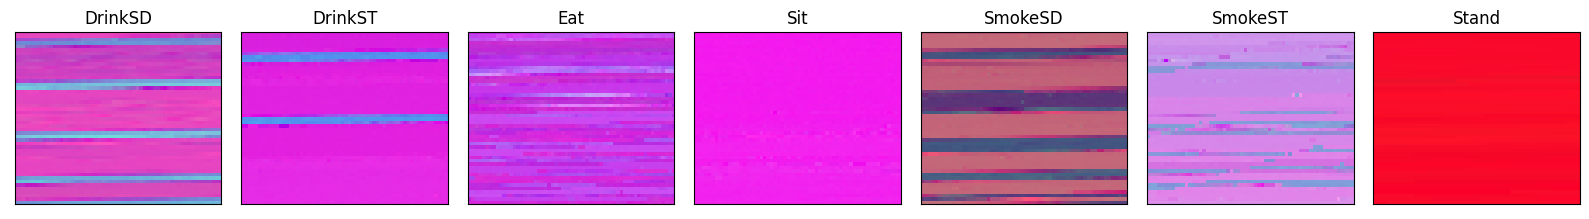

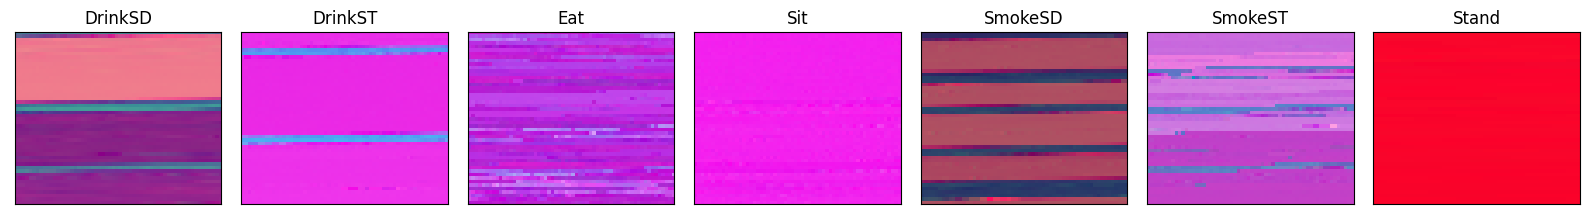

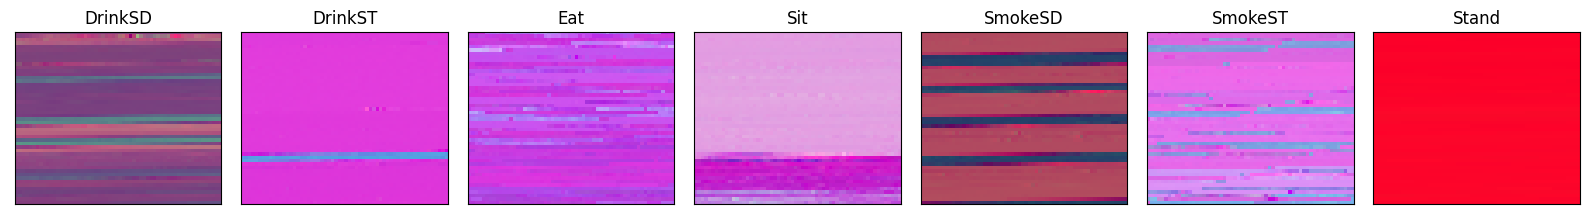

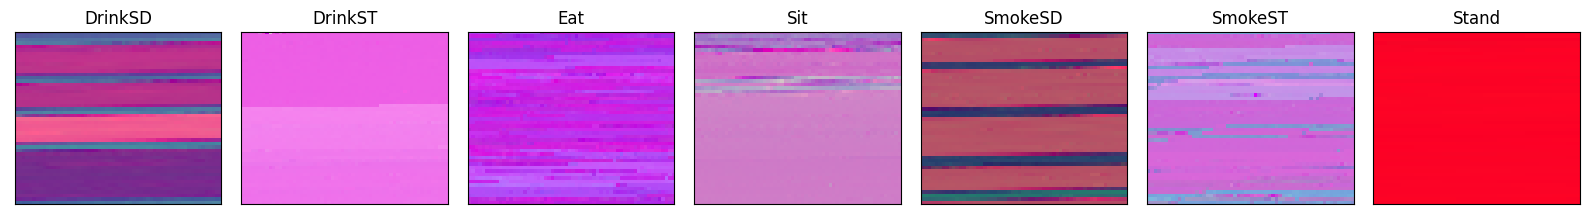

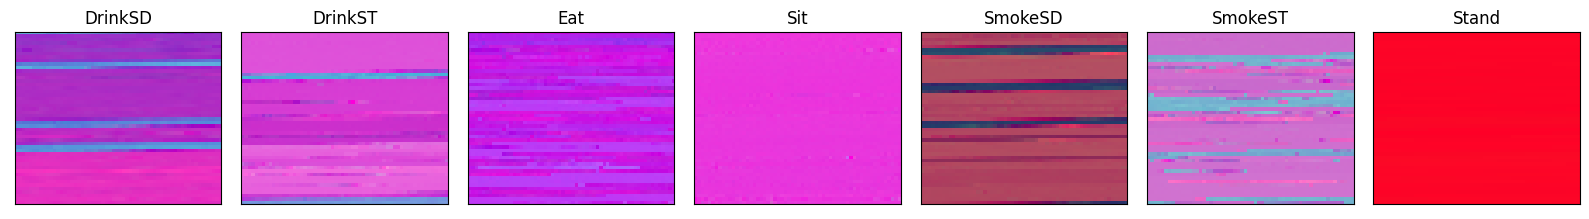

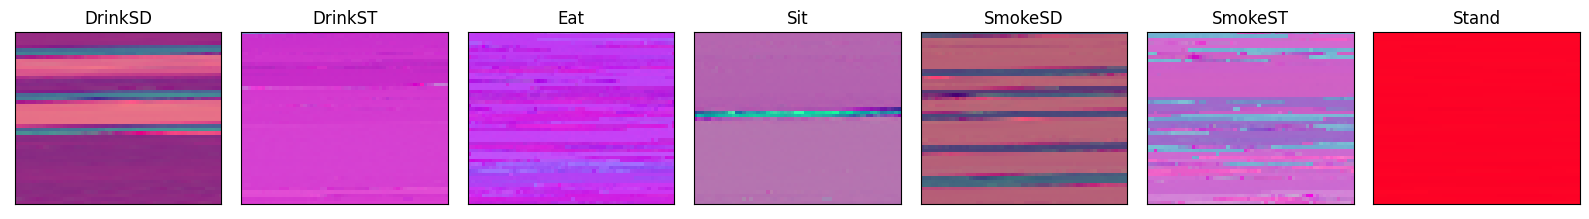

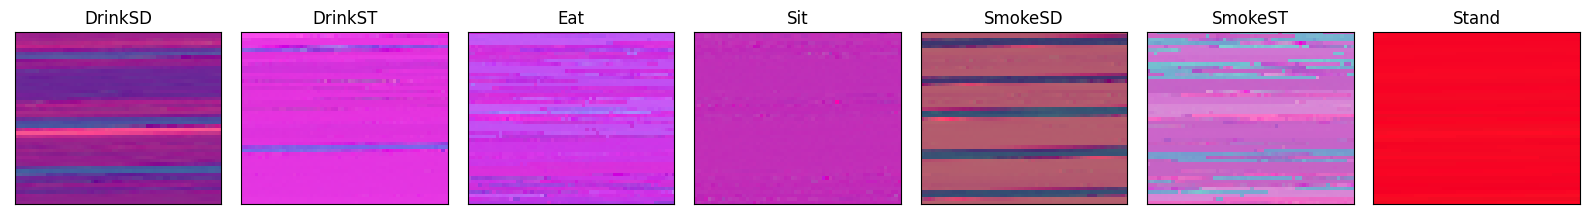

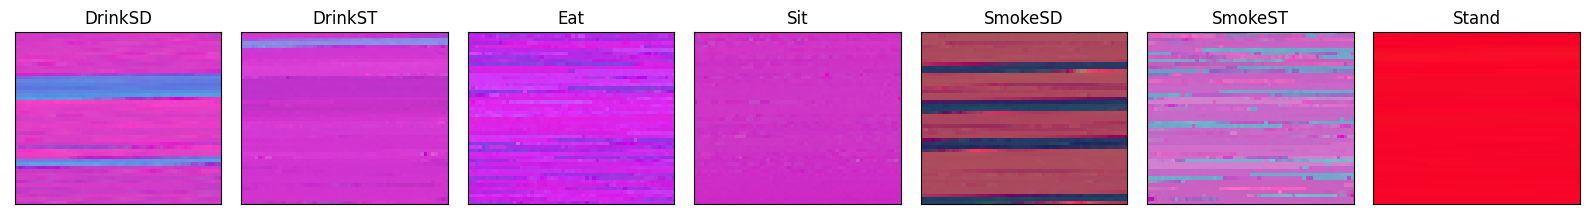

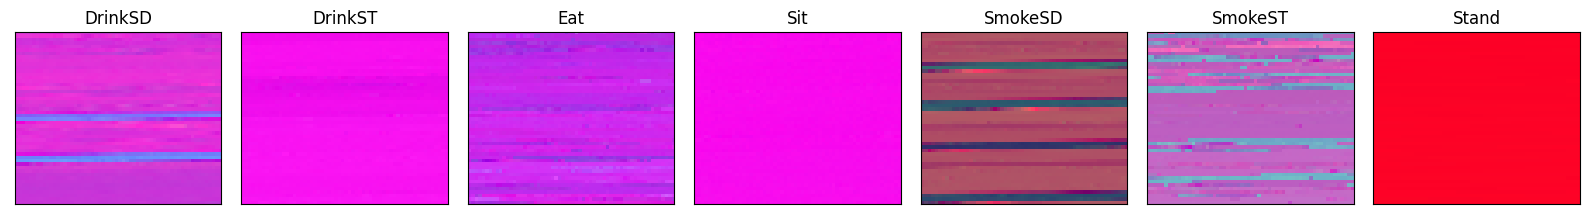

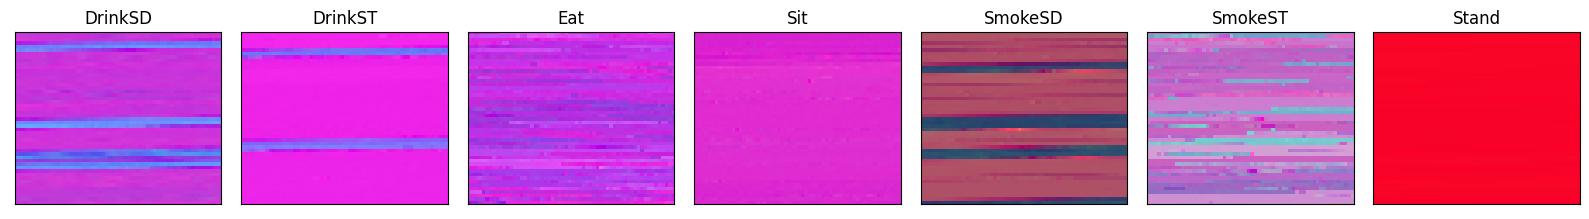

In [11]:
#keep made images in book...
if sensor == "accel" : 
    for n_row in range(1,20):
      n_act=0
      fig, axs = plt.subplots(1, n_act_types, figsize=(16, 9))
      for i in range(n_act_types):
        ax = axs[i]
        ax.set_title(f'{act_types[n_act]}', size=12)
        ax.set_xticks(()), ax.set_yticks(())
        ax.imshow(act_rgb[act_types[n_act]][n_row])
        n_act=n_act+1
      plt.tight_layout()

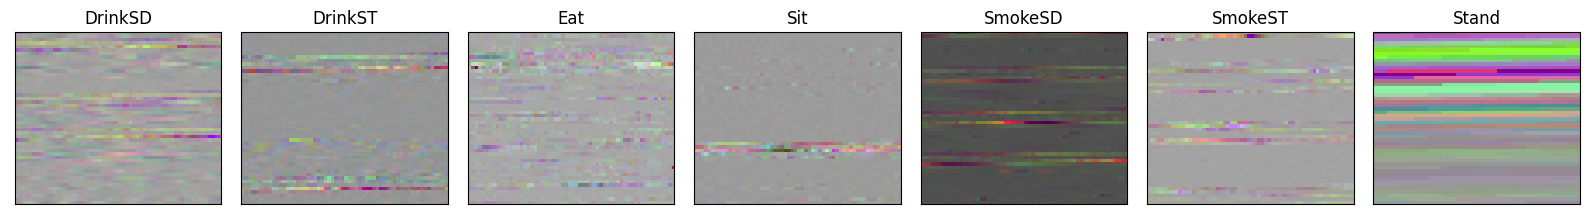

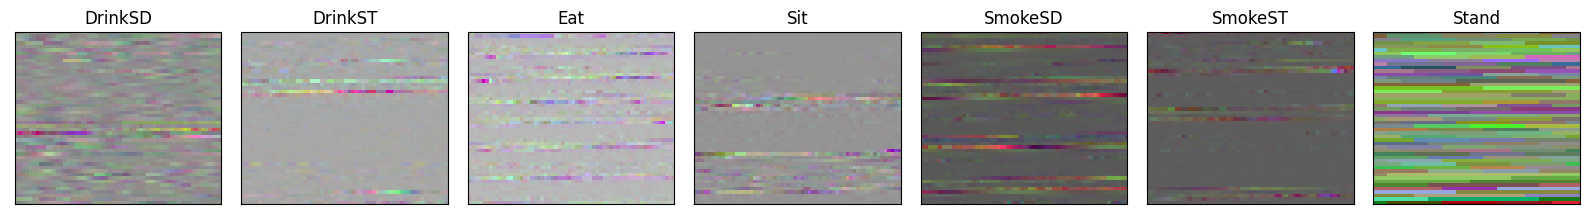

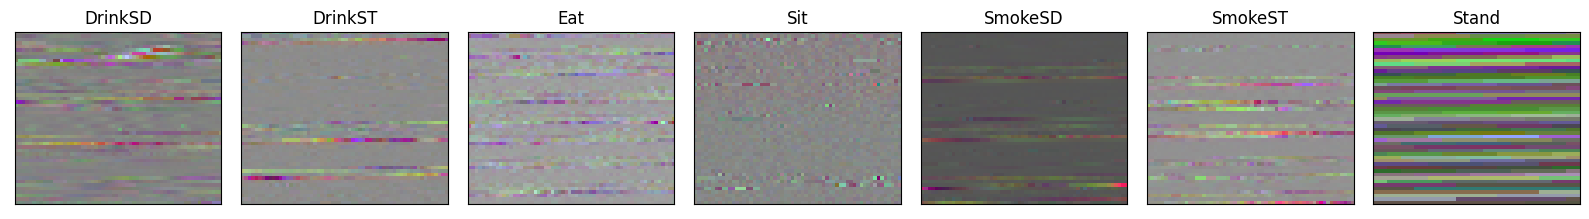

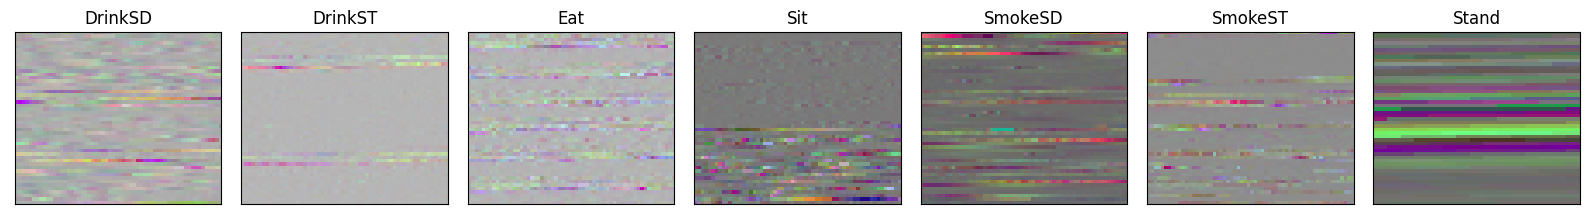

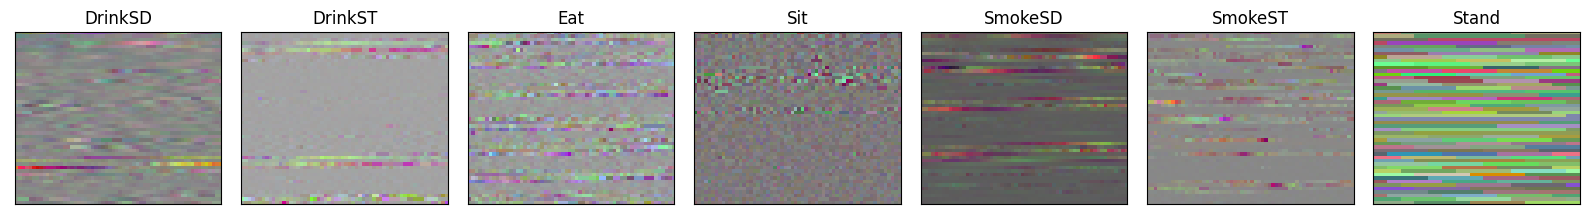

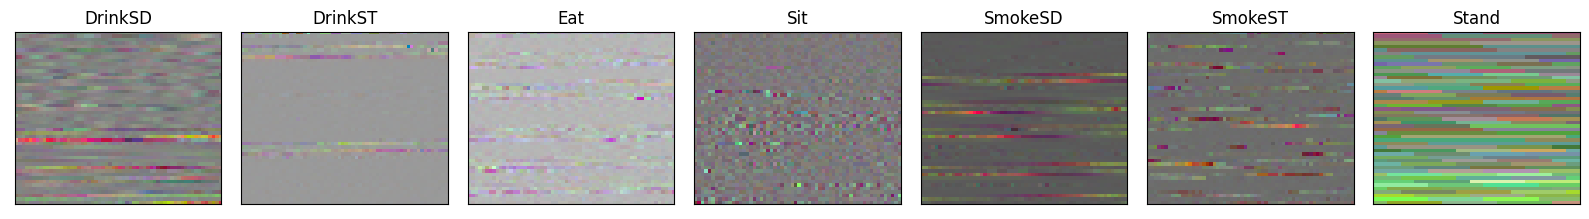

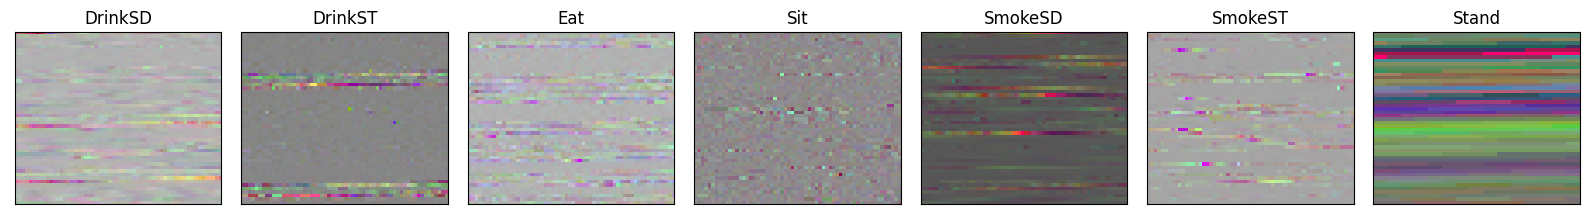

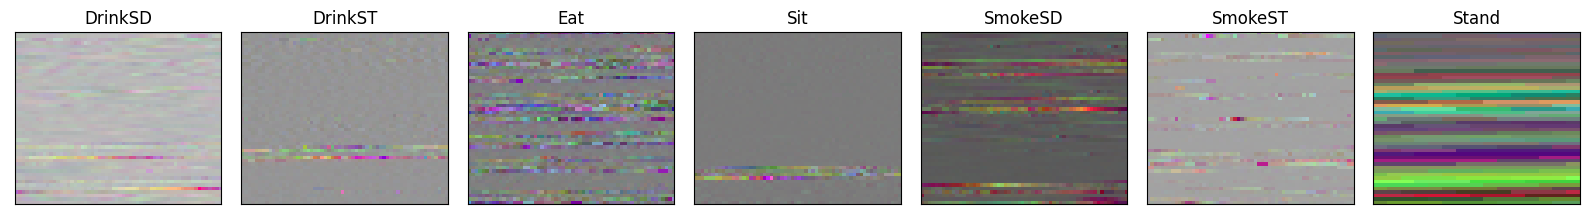

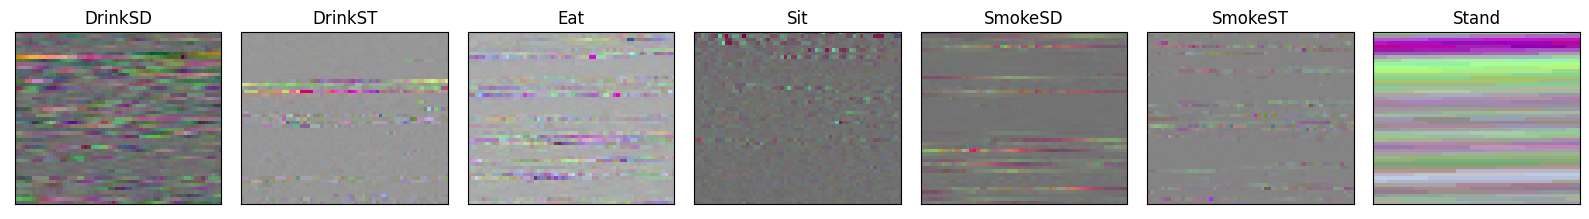

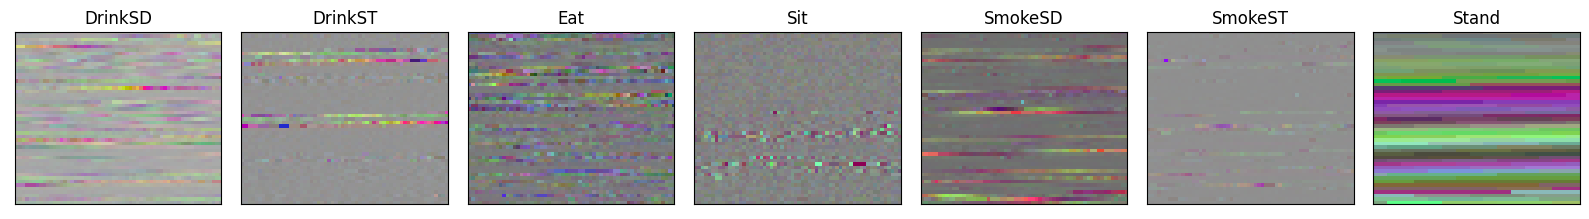

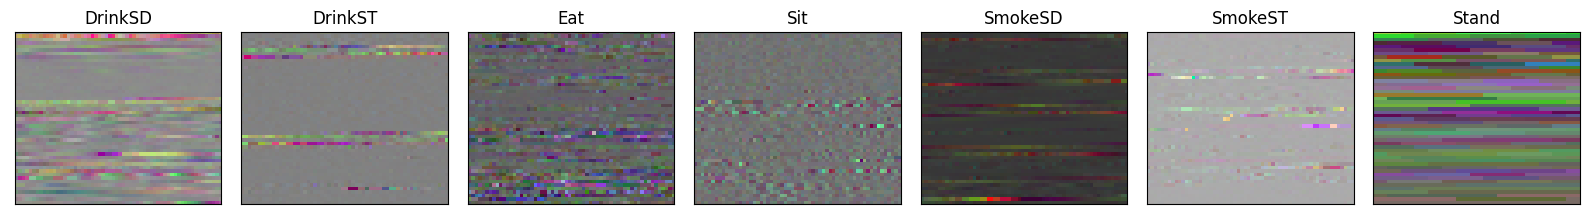

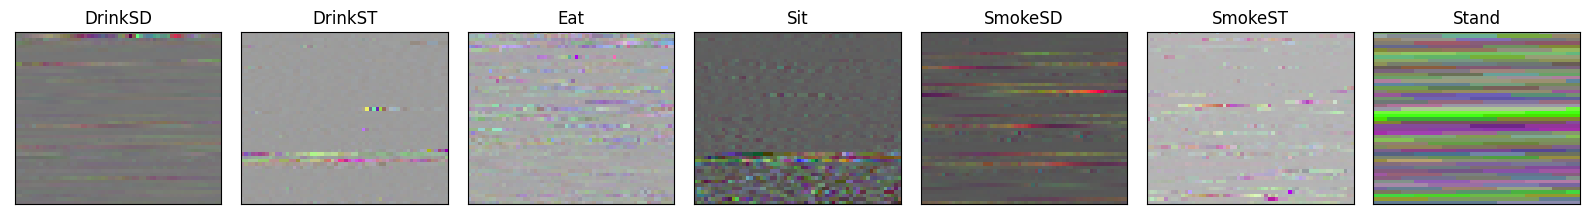

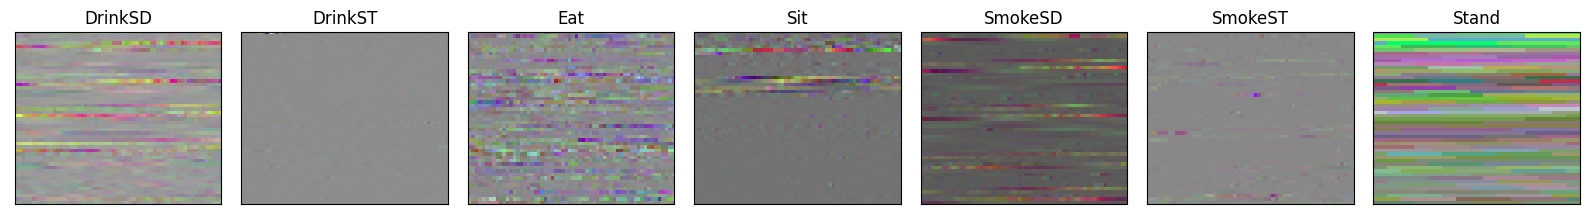

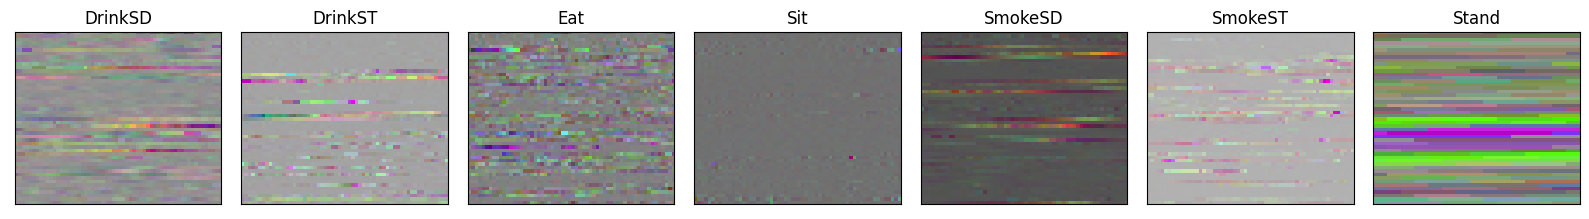

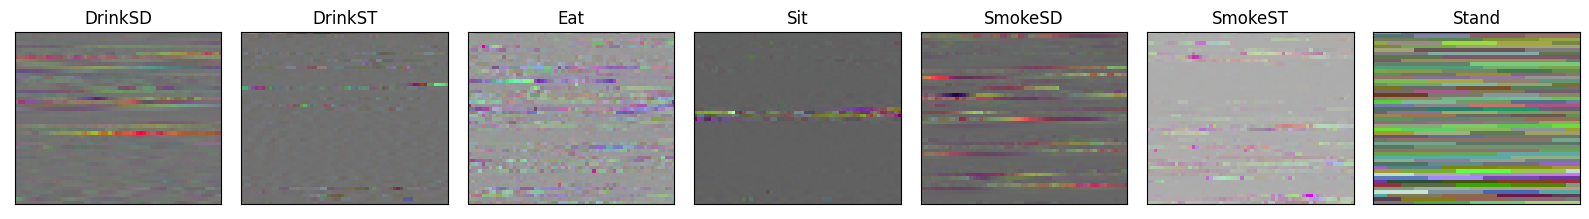

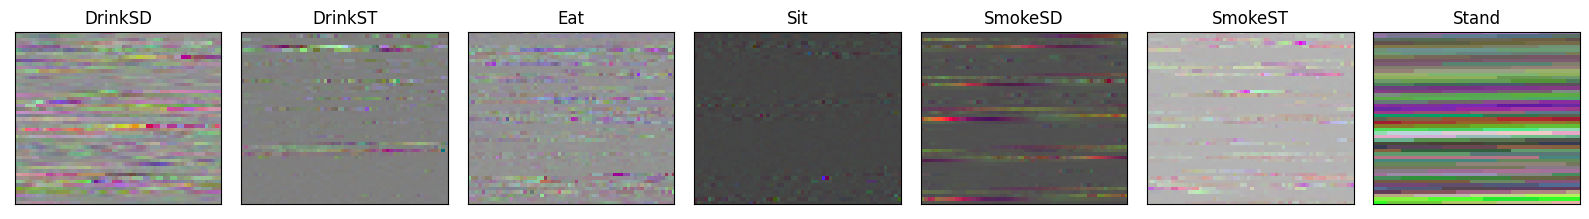

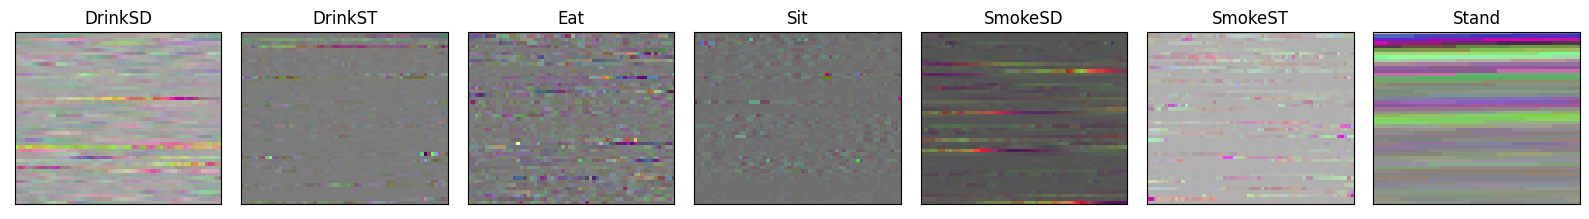

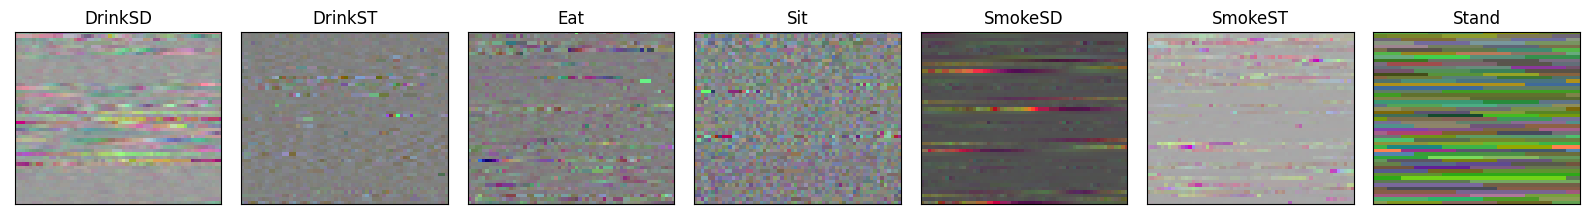

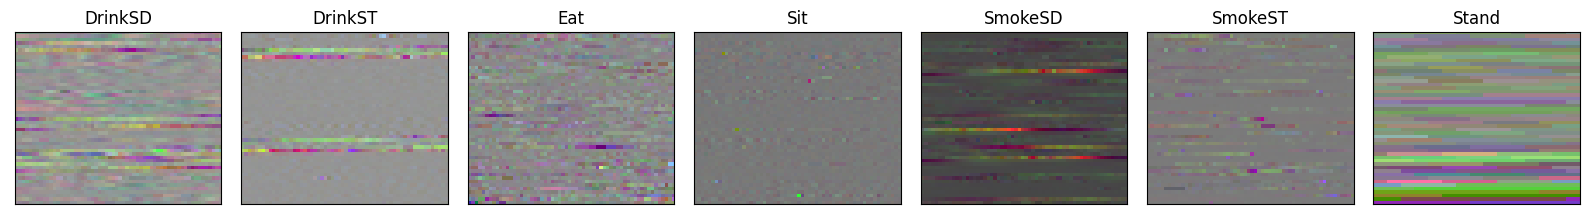

In [13]:
#keep images in book...
if sensor == "accel_lin" : 
    for n_row in range(1,20):
      n_act=0
      fig, axs = plt.subplots(1, n_act_types, figsize=(16, 9))
      for i in range(n_act_types):
        ax = axs[i]
        ax.set_title(f'{act_types[n_act]}', size=12)
        ax.set_xticks(()), ax.set_yticks(())
        ax.imshow(act_rgb[act_types[n_act]][n_row])
        n_act=n_act+1
      plt.tight_layout()

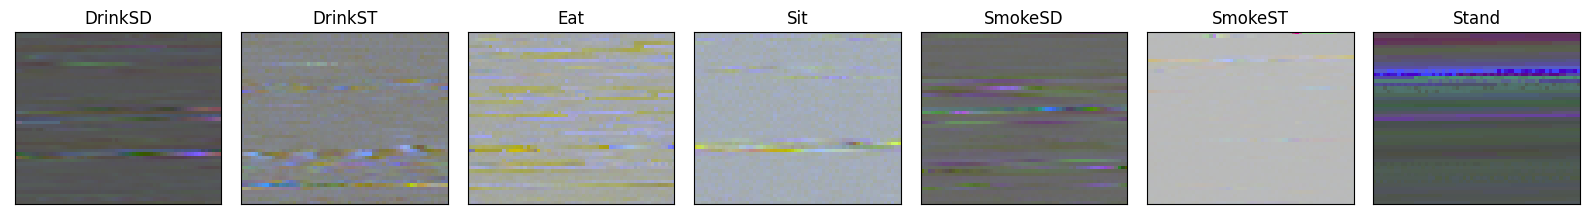

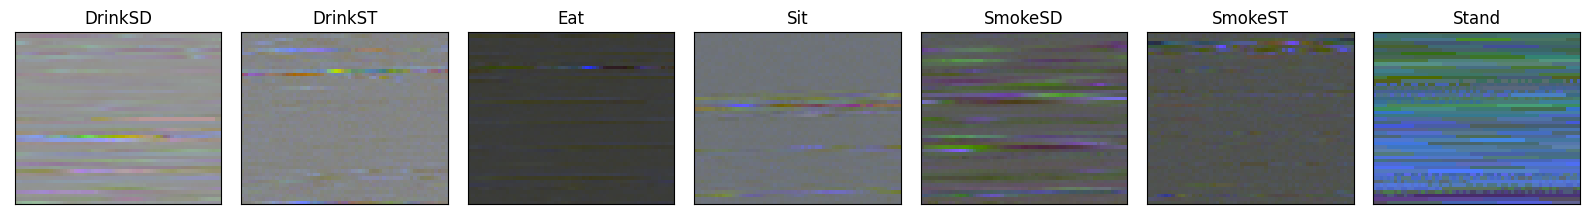

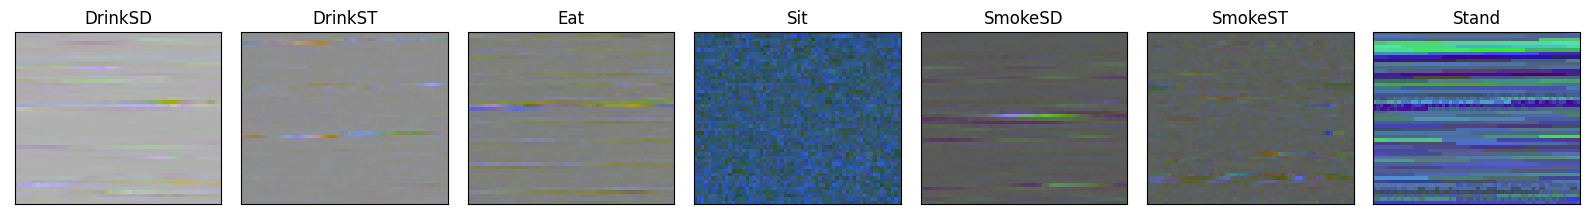

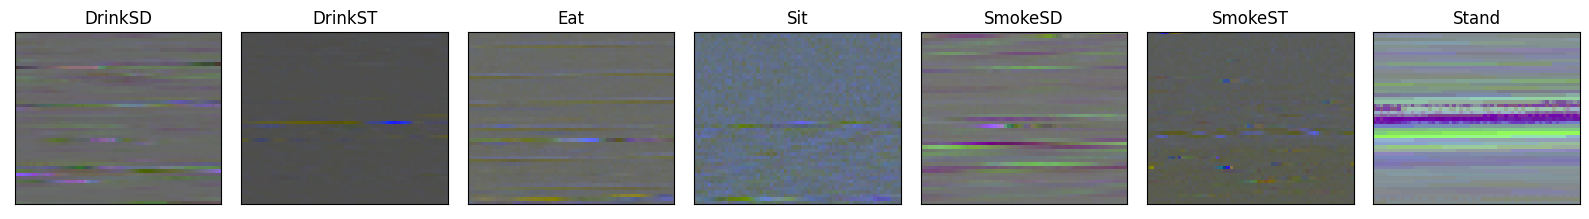

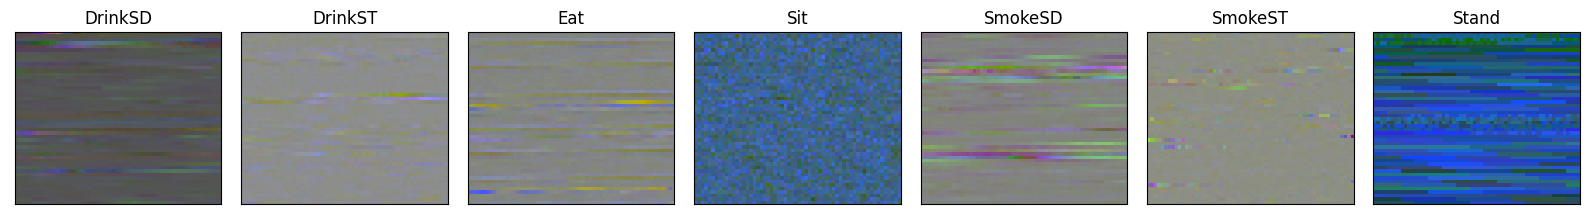

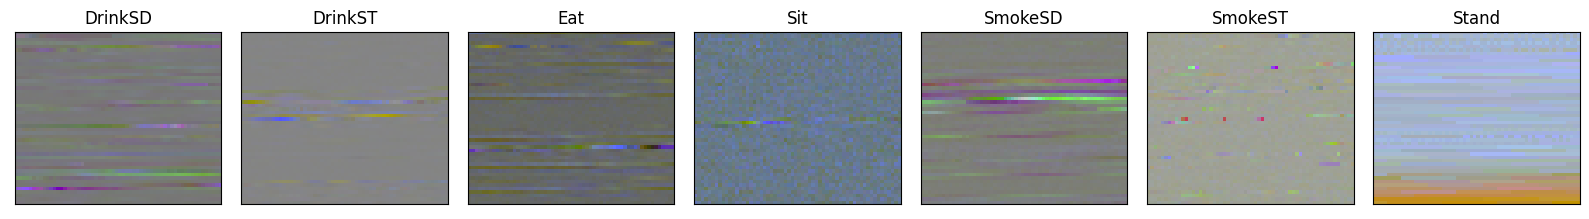

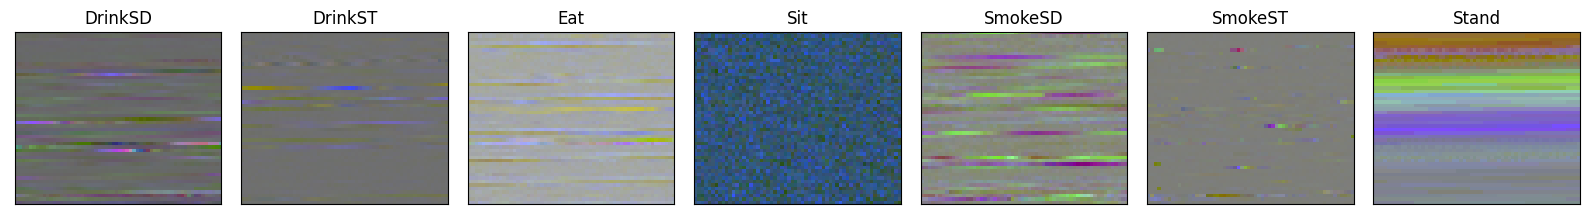

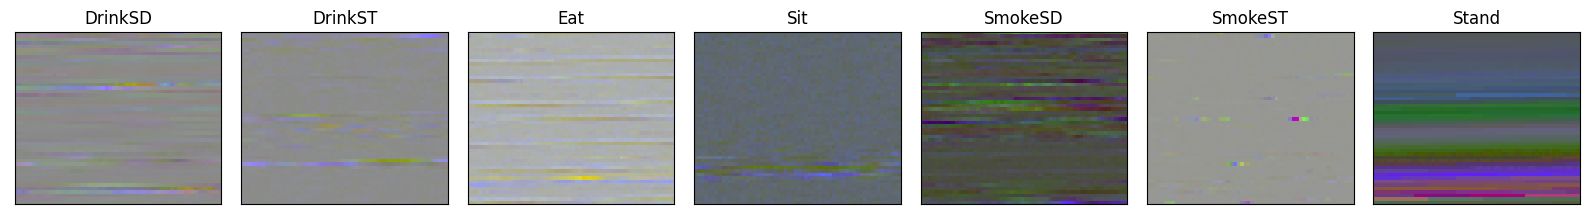

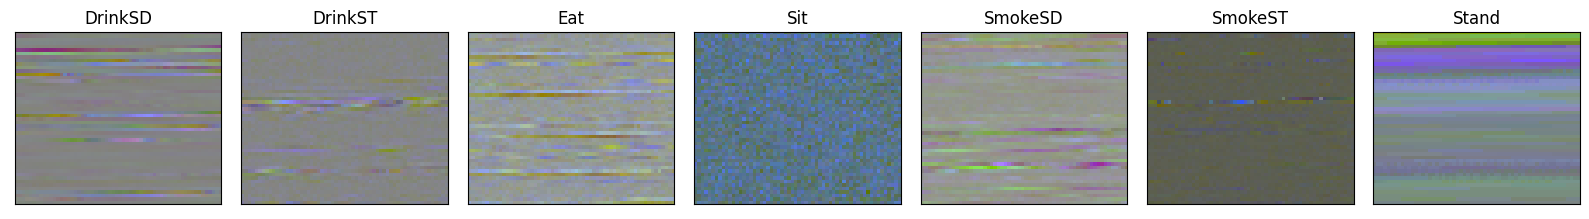

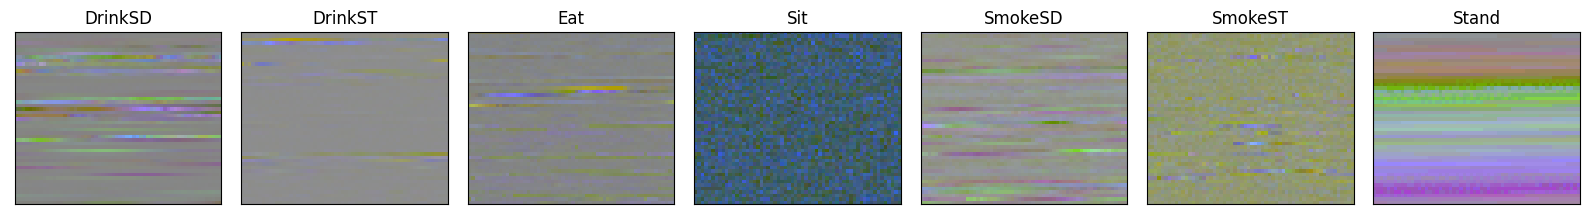

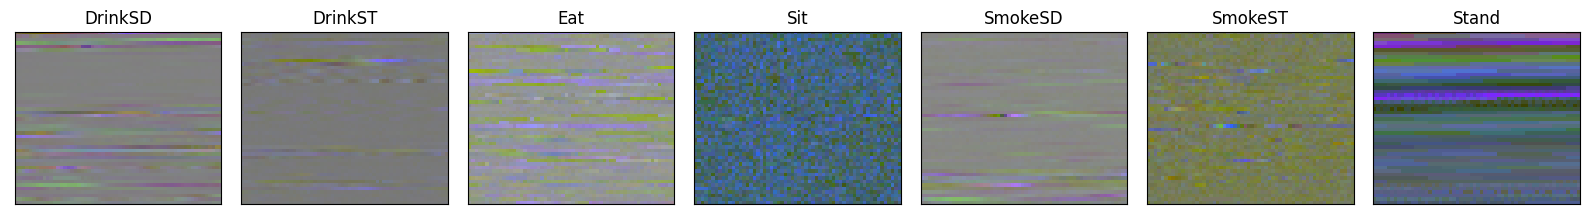

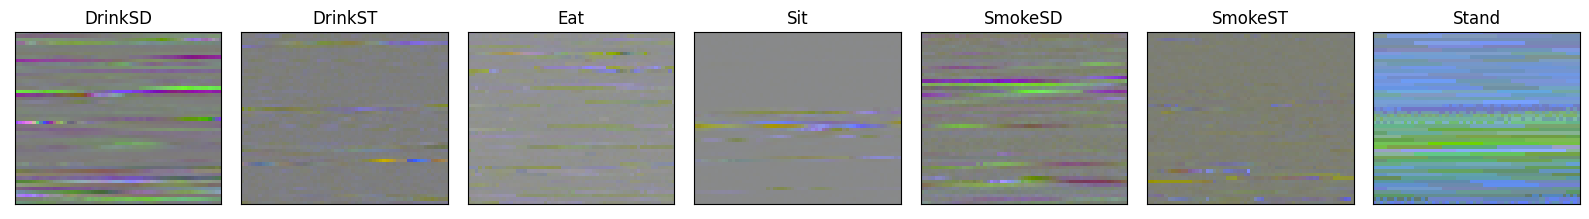

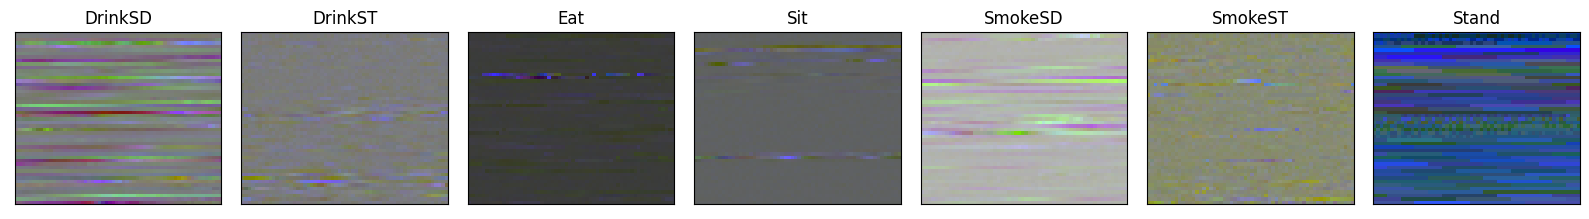

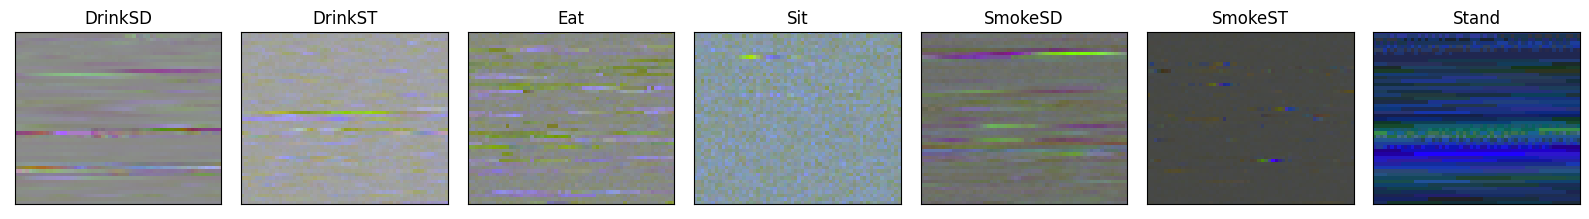

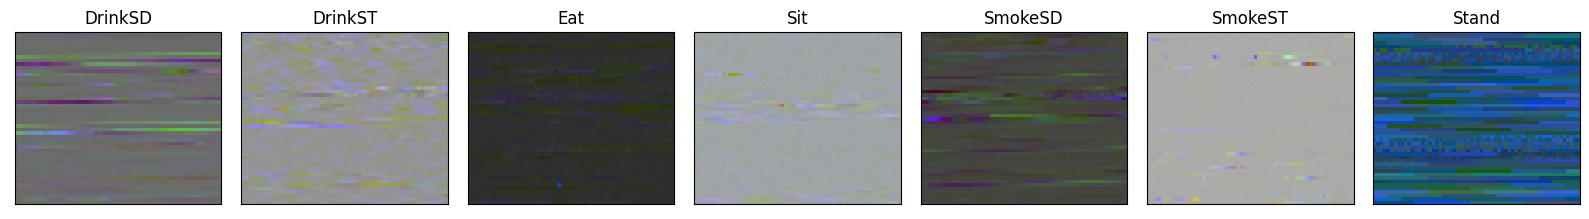

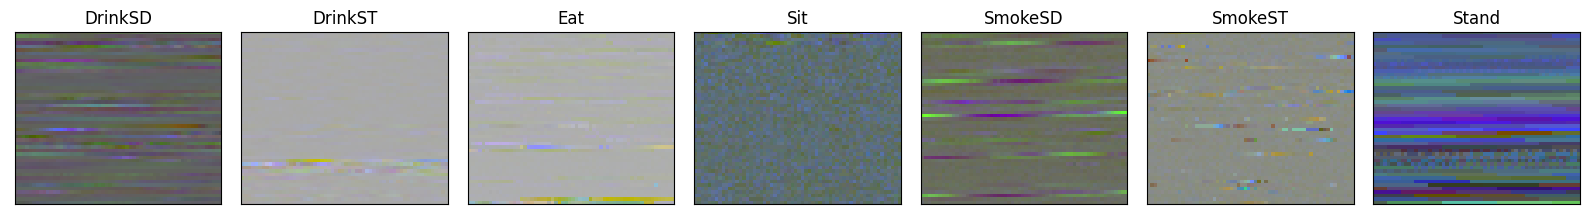

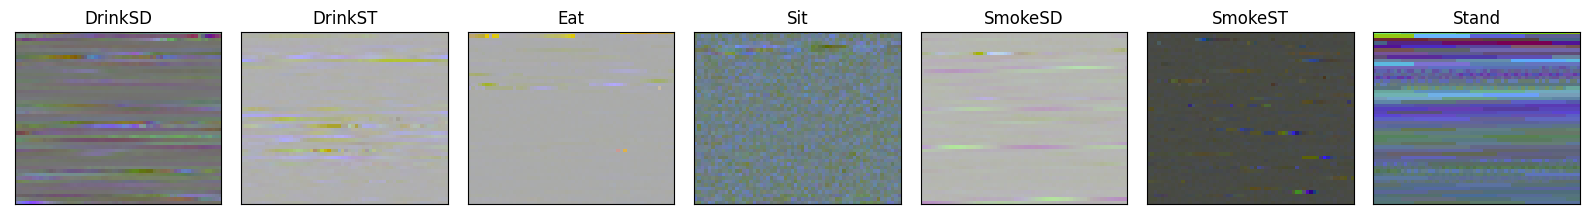

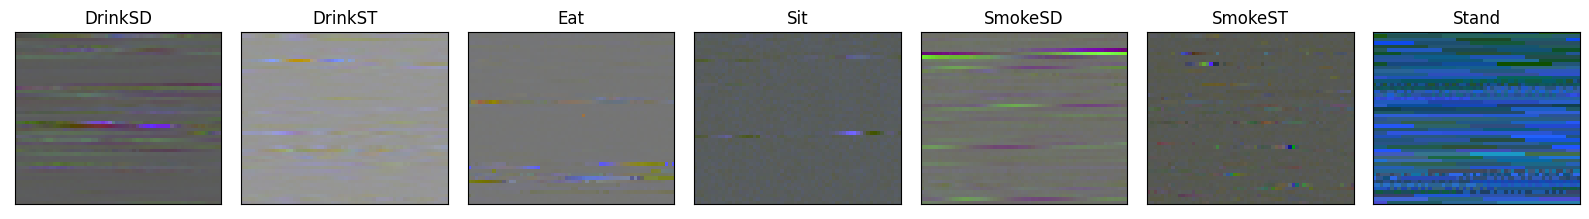

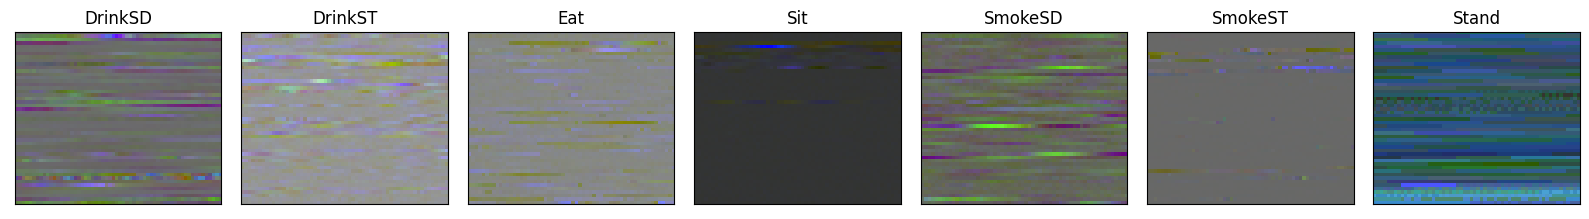

In [15]:
#keep images in book...
if sensor == "gyro" : 
    for n_row in range(1,20):
      n_act=0
      fig, axs = plt.subplots(1, n_act_types, figsize=(16, 9))
      for i in range(n_act_types):
        ax = axs[i]
        ax.set_title(f'{act_types[n_act]}', size=12)
        ax.set_xticks(()), ax.set_yticks(())
        ax.imshow(act_rgb[act_types[n_act]][n_row])
        n_act=n_act+1
      plt.tight_layout()